In [1]:
from utils import (
    conf_ini,
    time_step,
    calc_energy,
    plot_dev_over_time,
    plot_energy_over_time,
    perturbate,
    calc_pos_deviation,
    verlet_list,
)
import numpy as np


In [2]:
L = 4
N = L * L

# density
rho = 0.6
# box size length
boxsize = np.sqrt(N / rho)

temper = 1.05

# Lennard-Jones cut radius
rcut = boxsize / 3
rcut = rcut**2

# Verlet list radius
rv = boxsize / 2.5
rv = rv**2

# Parameters of the lennard-jones potential
depth = 1
part_size = 1
mass = 1

dt = 0.0005


In [3]:
# initialize the reference state
ref_state = conf_ini(N, boxsize, temper)
nviz, viz = verlet_list(ref_state, rv, boxsize)

# amount of perturbation of the initial positions
pert_amount = [10**-3, 10**-6, 10**-9]

# create new states which are perturbed versions of ref_state
pert_states = [
    perturbate(ref_state, part_size, amount, boxsize, N) for amount in pert_amount
]
pert_nviz = pert_viz = dev_over_time = [[] for _ in pert_amount]

for index, pert_state in enumerate(pert_states):
    pert_nviz[index], pert_viz[index] = verlet_list(pert_state, rv, boxsize)

dev_over_time = [[] for _ in pert_amount]
kin_energy_over_time = []
pot_energy_over_time = []
total_over_time = []

iterations = 10000

for _ in range(iterations):
    # do the verlet integrations for ref_state
    ref_state, nviz, viz = time_step(
        ref_state, nviz, viz, dt, boxsize, N, rv, rcut, part_size, depth, mass
    )

    # do the verlet integrations for the perturbed states
    for index, pert_state in enumerate(pert_states):
        pert_state, pert_nviz[index], pert_viz[index] = time_step(
            pert_state,
            pert_nviz[index],
            pert_viz[index],
            dt,
            boxsize,
            N,
            rv,
            rcut,
            part_size,
            depth,
            mass,
        )

        # calculate position deviation at current iteration
        deviation = calc_pos_deviation(ref_state, pert_state, N)
        dev_over_time[index].append(deviation)

    kin, pot, total = calc_energy(ref_state, N, mass)
    kin_energy_over_time.append(kin)
    pot_energy_over_time.append(pot)
    total_over_time.append(total)


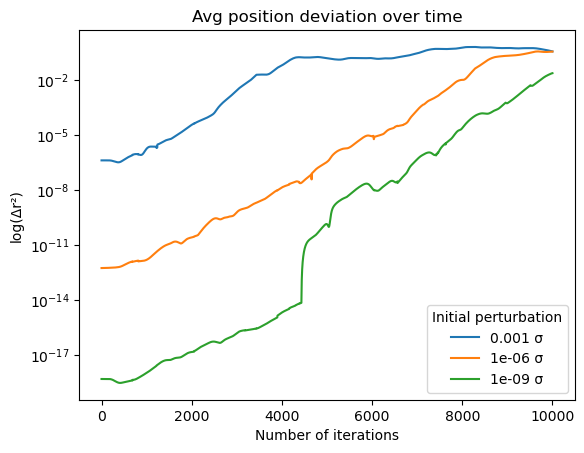

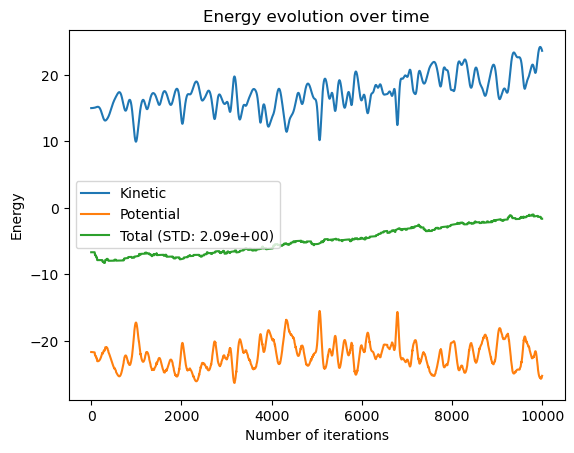

In [4]:
plot_dev_over_time(dev_over_time, pert_amount)
plot_energy_over_time(kin_energy_over_time, pot_energy_over_time, total_over_time)
